# Исследование рынка вакансий Начинающих аналитиков

Аналитик Постникова Екатерина

1. [Описание и цели](#objectives)
2. [План исследования](#plan)
3. [Сбор данных о вакансиях](#api)
    * [Обзор и сравнение источников данных](#source)    
    * [Параметры сбора данных о вакансиях](#params)
    * [Сбор и сохранение данных](#mining)
    
4. [Исследование рынка работодателей для начинающих аналитиков](#eda_industry)
5. [Оценка объема рынка младших аналитиков в Москве и Санкт-Петербурге](#volume)
6. [Выводы](#summary)

In [1]:
# загрузка библиотек

import pandas as pd
import requests
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Описание и цели<a id="objectives"></a>

- Провести исследование рынка работодателей для начинающих (джуниор) аналитиков. Посмотреть на сегментацию компаний, в которых востребованы младшие аналитики.
- Оценить объем спроса на джуниор-аналитиков в России. Оценить объем рынка младших аналитиков в Москве и Санкт-Петербурге.

<a id="plan"></a>
## План исследования рынка работодателей и оценки объема спроса на джуниор-аналитиков

1. Определить источник данных о вакансиях

2. Собрать данные о вакансиях:
 - изучить инструменты доступа к открытым данным выбранного источника
 - сформулировать параметры запроса для выборки подходящих вакансий
 - определить формат сбора данных, перечень полей, необходимых для исследования

3. Провести исследовательский анализ данных о вакансиях по целевым задачам

 - определить отрасли работодателей для начинающих аналитиков
 - оценить объем спроса на джуниор-аналитиков в Москве и Санкт-Петербурге.

4. Подготовить презентацию с результатами исследования

## Сбор данных о вакансиях <a id="api"></a>


### Обзор и сравнение источников данных <a id="source"></a>

**Для выбора источника данных для исследования я провела небольшой сравнительных анализ трех платформ:**

- Популярный западный портал по трудоустройству indeed.com
- Государственный российский портал "Работа в России"
- hh.ru

**Критерии оценки источников данных:**

- Удобный доступ к открытым данным
- Объем выдачи вакансий по тестовому поисковому запросу "Аналитик" по городу Москва

Сравнительная таблица источников по параметрам представлена в презентации исследования. 

**HH.RU**, крупнейшая российская компания интернет-рекрутмента, превзошла в сравнительном анализе другие площадке и  была выбрана мной в качестве источника данных для исследования.

**Минусы неотобранных площадок:**

- Официальный портал "Работа в России" https://trudvsem.ru/. По тестовому поиску по Москве по слову "Аналитик" нашлось всего 7 вакансий.

- Крупный западный портал indeed.com. Не смотря на то, что удобно представлены открытые данные (кроме  доступа по api есть готовые выгруженные таблицы с данными по профессиям Analyst и Data Scientist на Kaggle), портал indeed.com в 8 раз уступает hh.ru по объему выданных вакансий по тестовому запросу. Большинство вакансий дублируют имеющиеся на hh.ru.

### Параметры сбора данных о вакансиях

**Цель:** Получение выгрузки открытых вакансий "Младших аналитиков", размещенных на ресурсе hh.ru, для дальнейшего исследования.

**Инстурменты:** Работа с API hh.ru в рамках стандартных разрешений для анонимного пользователя.

**Параметры запроса:**

- Требования к соискателям по опыту: без опыта и опыт 1-3 года
- Поиск в рамках наименования вакансии по ключевым словам "Аналитик" (исключая: "старший", "начальник", "директор 1С", "бизнес-аналитик")

**Поля, по которым осуществляется выгрузка вакансий:**

- Дата публикации
- Наименование вакансии
- Ссылка на вакансию
- Требуемый опыт работы от соискателя (без опыта или 1-3 года)
- Город
- Работодатель
- Индустрия

**Так как выгрузка вакансий по api hh.ru ограничивается 2000 записей, разделим процедуру выгрузки данных на 2 этапа:**

- выгрузка всех вакансий, удовлетворяющих условиям, с параметром "опыт не требуется" без определенной локации
- дополнительная выгрузка вакансий Москвы и Санкт-Петербурга для Аналитиков с опытом от 1 года.

### Сбор и сохранение данных о вакансиях <a id="mining"></a>

**<span style="color:green">Важно! Этот этап можно пропустить, не запуская ячейки. Так как загрузка информации о вакансиях по api hh.ru требует значительного времени, то для удобства вместе с проектом в архиве я приложила уже готовый сформированный мною файл вакансий 'hh_vacancies_dump.csv' (актуальность архива - 29.04.2020).</span>**


Технический сбор данных о вакансиях по api и сохранение файла в формате csv для дальнейшего исследования.

In [2]:
# функция запроса по api

def download_hh_vacancies(url, experience, page, area):
    BASE_URL = url
    params = {"experience" : experience,
              "page" : page,
              "area" : area,
              "text" : "NAME:((аналитик OR analyst) and NOT (1С or 1С or директор or начальник or старший or бизнес-аналитик))"
    }
    response = requests.get(BASE_URL, params=params)
    return response.text

In [3]:
# функция выгрузки данных о вакансиях по параметрам

def create_df_vacancies(pages, experience, area):
    
    hh_ru = pd.DataFrame(columns = ['published_at', 'name', 'url', 'experience', 'city' ,'employer', 'industry'])
    
    for i in range(pages):
        x = download_hh_vacancies(BASE_URL, experience, i, area)
        items = json.loads(x)['items']
        
        for k in items:
            try:
                url_emp = "https://api.hh.ru/employers/"+k['employer']['id']
                emp = requests.get(url_emp).text
                industr = json.loads(emp)['industries']
                
                for h in industr:
                    hh_ru = hh_ru.append({'published_at':k['published_at'], 'name':k['name'], 'url': k['alternate_url'], 'experience': experience,
                                  'city': k['area']['name'], 'employer': k['employer']['name'], 'industry': h['id'] }, ignore_index=True)
            except:
                print('Не указан работодатель у вакансии '+k['id'])
    return hh_ru

In [4]:
# задаем параметры для выгрузки вакансий начинающих аналитиков по api

BASE_URL = "https://api.hh.ru/vacancies" 

### Вакансии с параметром "Опыт не требуется" по всем странам и регионам

Для исследования рынка работодателей для младших аналитиков нам необходимы данные по всем релевантным вакансиям "без опыта" не зависимо от места локации работодателя.

In [5]:
# устанавливаем параметры запроса к hh.ru 

experience1 = 'noExperience'
page = 0
area = []
x = download_hh_vacancies(BASE_URL, experience1, page, area)
pages = json.loads(x)['pages']

In [6]:
pages

28

In [7]:
# загружаем результаты запроса в датафрейм

data_no_exp = create_df_vacancies(pages, experience1, area)

In [8]:
# обзор первых строк датасета

data_no_exp.head()

,published_at,name,url,experience,city,employer,industry
0,2020-04-29T16:53:45+0300,Аналитик,https://hh.ru/vacancy/36806183,noExperience,Краснодар,Пятерочка,41.517
1,2020-04-29T14:45:32+0300,Аналитик,https://hh.ru/vacancy/36551177,noExperience,Москва,ДомКлик,7.541
2,2020-04-29T14:45:32+0300,Аналитик,https://hh.ru/vacancy/36551177,noExperience,Москва,ДомКлик,7.540
3,2020-04-29T13:59:21+0300,Аналитик,https://hh.ru/vacancy/36803473,noExperience,Ташкент,Key Consulting,44.393
4,2020-04-29T12:45:15+0300,Аналитик,https://hh.ru/vacancy/36646970,noExperience,Москва,"ОМТ-Консалт, Группа компаний",44.393


In [9]:
# с какого числа попали вакансии в выборку по запросу

data_no_exp['published_at'].min()

'2020-03-23T18:40:45+0300'

Выгружены релевантные вакансии, опубликованные с 23 марта по 29 апреля 2020.

### Выгрузка вакансий Москвы и Санкт-Петербурга для Аналитиков с опытом от 1 года

На предыдущем этапе мы получили выборку по всем вакансиям Аналитиков, включая Москву и Санкт-Петербург, не требующих от соискателей начального опыта. Но для детального исследования рынка вакансий по двум крупнейшим городам России дополнительно загрузим выборку вакансий с требованиями к Аналитикам по опыту работы от 1 до 3 лет.

In [10]:
# параметры запроса к hh.ru: опыт работа - 1-3 года, города поиска - Москва и Санкт-Петербург

experience2 = 'between1And3'
page = 0
area_moscow_spb = ['1', '2']
x = download_hh_vacancies(BASE_URL, experience2, page, area_moscow_spb)
pages = json.loads(x)['pages']
pages

61

In [11]:
# загрузка выборки вакансий по параметрам

data_exp_1And3 = create_df_vacancies(pages, experience2, area_moscow_spb)

Не указан работодатель у вакансии 36610232
Не указан работодатель у вакансии 36612817
Не указан работодатель у вакансии 36637822


In [12]:
data_exp_1And3.head()

,published_at,name,url,experience,city,employer,industry
0,2020-04-29T18:04:43+0300,Аналитик,https://hh.ru/vacancy/35927256,between1And3,Москва,Кворум,7.541
1,2020-04-29T16:11:22+0300,Аналитик,https://hh.ru/vacancy/35625987,between1And3,Москва,ГБУ МО МОМИАЦ,7.540
2,2020-04-29T16:11:22+0300,Аналитик,https://hh.ru/vacancy/35625987,between1And3,Москва,ГБУ МО МОМИАЦ,7.539
3,2020-04-29T14:15:42+0300,Аналитик,https://hh.ru/vacancy/36477513,between1And3,Москва,ТЭК-Торг,7.540
4,2020-04-29T14:15:42+0300,Аналитик,https://hh.ru/vacancy/36477513,between1And3,Москва,ТЭК-Торг,7.539


In [13]:
# дата самой "старой" вакансии из выборки

data_exp_1And3['published_at'].min()

'2020-03-05T16:25:51+0300'

In [14]:
# объединим обе загруженные выборки вакансий в один датасет

df = pd.concat([data_no_exp, data_exp_1And3], ignore_index=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 7 columns):
published_at    3194 non-null object
name            3194 non-null object
url             3194 non-null object
experience      3194 non-null object
city            3194 non-null object
employer        3194 non-null object
industry        3194 non-null object
dtypes: object(7)
memory usage: 174.8+ KB


### Сохранение вакансий в csv

Строка кода с сохранением полученного датасета в файл закомментирована, так как приложила в архиве готовый файл, выгруженный мной 29.04.2020.

In [16]:
# df.to_csv('hh_vacancies_dump.csv', index=False)

In [17]:
data = pd.read_csv('hh_vacancies_dump.csv')

In [18]:
# обзор датасета с входящими данными

data.head()

,published_at,name,url,experience,city,employer,industry
0,2020-04-29T12:45:15+0300,Аналитик,https://hh.ru/vacancy/36646970,noExperience,Москва,"ОМТ-Консалт, Группа компаний",44
1,2020-04-29T12:32:20+0300,Аналитик,https://hh.ru/vacancy/36526548,noExperience,Казань,Доронин Кирилл Леонидович,43
2,2020-04-29T11:24:52+0300,Аналитик,https://hh.ru/vacancy/36800265,noExperience,Челябинск,РИФАРМ,48
3,2020-04-29T11:11:55+0300,Data analyst,https://hh.ru/vacancy/36265344,noExperience,Киев,Smart Solutions,44
4,2020-04-29T09:43:09+0300,Game Analyst,https://hh.ru/vacancy/36798448,noExperience,Краснодар,Plarium,7


## Исследование рынка работодателей для начинающих Аналитиков <a id="eda_industry"></a>

Одной из задач исследования рынка работодателей провести сегментацию работодателей для младших аналитиков.

Требования, предъявляемые к начинающим аналитикам, варьируются в зависимости от вида деятельности предприятия. У каждой отрасли есть своя специфика.

Поэтому считаю важной классификацию работодателей по отраслям.

В структуре hh.ru указание индустрии не является обязательным полем, но у большинства компаний оно заполнено. Компании в праве указать несколько видов деятельности. Код индустрии, это детализированная характеристика, множество кодов относится к одной и той же отрасли. 

Для систематизации и классификации работодателей по отраслям, произведем замену кода деятельности на "родительский" код отрасли, согласно справочнику отраслей документации api hh.ru. 

In [19]:
# заменим код индустрии вакансий на "родительский" код отрасли

df['industry'] = df['industry'].apply(lambda x: x.split('.')[0])

In [20]:
# удалим дубликаты

df.drop_duplicates(inplace=True)

In [21]:
# загрузим словарь кодов и наименований отраслей по api hh.ru

industry_url = "https://api.hh.ru/industries"
response = requests.get(industry_url)
ind_search = json.loads(response.text)

industry_dict = {j['id']:j['name'] for j in ind_search}

industry_dict

{'5': 'Перевозки, логистика, склад, ВЭД',
 '7': 'Информационные технологии, системная интеграция, интернет',
 '8': 'Электроника, приборостроение, бытовая техника, компьютеры и оргтехника',
 '9': 'Телекоммуникации, связь',
 '11': 'СМИ, маркетинг, реклама, BTL, PR, дизайн, продюсирование',
 '13': 'Строительство, недвижимость, эксплуатация, проектирование',
 '15': 'Автомобильный бизнес',
 '19': 'Лесная промышленность, деревообработка',
 '24': 'Металлургия, металлообработка',
 '27': 'Продукты питания',
 '29': 'Сельское хозяйство',
 '33': 'Тяжелое машиностроение',
 '34': 'Химическое производство, удобрения',
 '36': 'Государственные организации',
 '37': 'Общественная деятельность, партии, благотворительность, НКО',
 '39': 'Образовательные учреждения',
 '41': 'Розничная торговля',
 '42': 'Товары народного потребления (непищевые)',
 '43': 'Финансовый сектор',
 '44': 'Услуги для бизнеса',
 '45': 'Добывающая отрасль',
 '46': 'Энергетика',
 '47': 'Нефть и газ',
 '48': 'Медицина, фармацевтика, апт

In [22]:
# заполним название отрасли по словарю

data['industry'] = data['industry'].astype('str')
data['industry_name']= data['industry'].map(industry_dict)

In [23]:
data.head()

,published_at,name,url,experience,city,employer,industry,industry_name
0,2020-04-29T12:45:15+0300,Аналитик,https://hh.ru/vacancy/36646970,noExperience,Москва,"ОМТ-Консалт, Группа компаний",44,Услуги для бизнеса
1,2020-04-29T12:32:20+0300,Аналитик,https://hh.ru/vacancy/36526548,noExperience,Казань,Доронин Кирилл Леонидович,43,Финансовый сектор
2,2020-04-29T11:24:52+0300,Аналитик,https://hh.ru/vacancy/36800265,noExperience,Челябинск,РИФАРМ,48,"Медицина, фармацевтика, аптеки"
3,2020-04-29T11:11:55+0300,Data analyst,https://hh.ru/vacancy/36265344,noExperience,Киев,Smart Solutions,44,Услуги для бизнеса
4,2020-04-29T09:43:09+0300,Game Analyst,https://hh.ru/vacancy/36798448,noExperience,Краснодар,Plarium,7,"Информационные технологии, системная интеграци..."


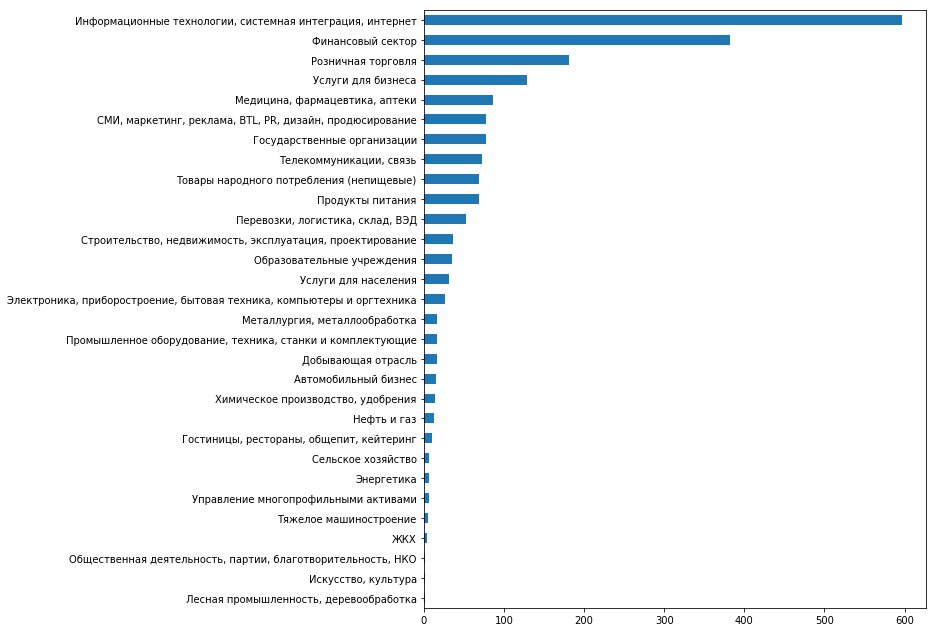

In [24]:
# Отрасли по объему вакансий младших аналитиков

data['industry_name'].value_counts().sort_values().plot(kind='barh', figsize=(9,11));

### ТОП-10 отраслей по объему вакансий для младших аналитиков

ТОП отраслей сформируем, исключая отрасль "Услуги для бизнеса", так как в эту категорию большей частью попали вакансии крупных рекрутинговых агентств. 

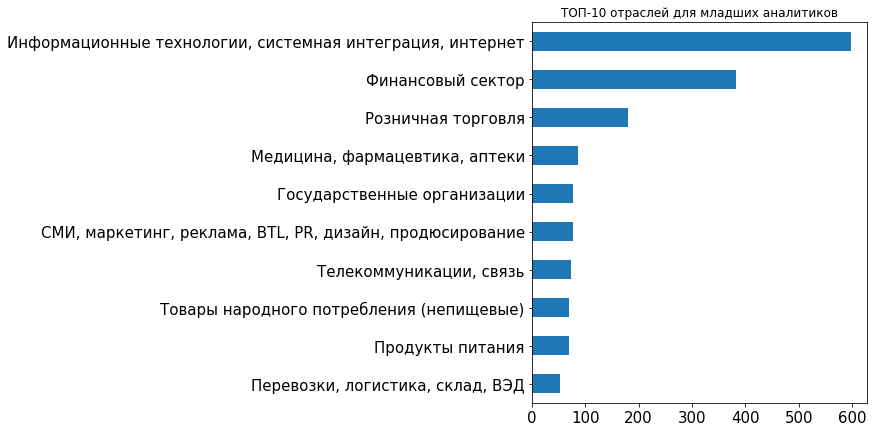

In [25]:
top10industry = data.query('industry_name != "Услуги для бизнеса"')['industry_name'].value_counts().head(10)
top10industry.sort_values().plot(kind='barh', figsize=(6,7), title='ТОП-10 отраслей для младших аналитиков', fontsize='15');

### Компании-работодатели топовых отраслей для младших аналитиков

In [26]:
# фильтр по топовым отраслям для аналитиков

top_filter = data.query('industry_name != "Услуги для бизнеса"')['industry_name'].value_counts().head(10).index

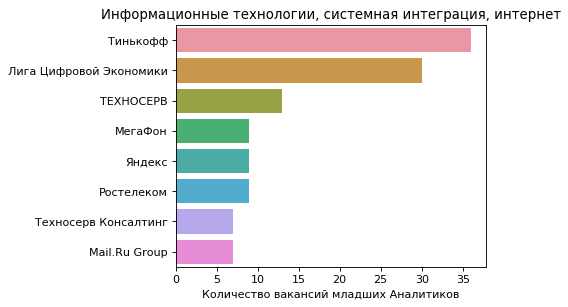

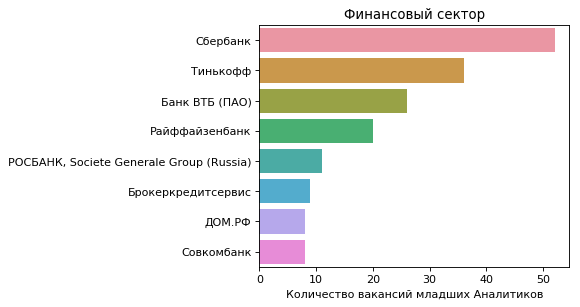

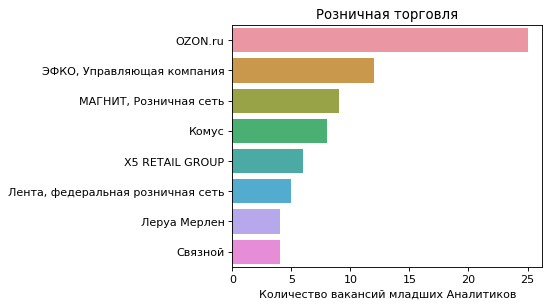

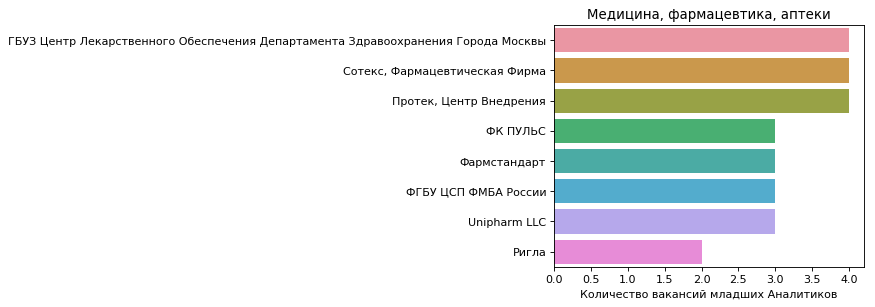

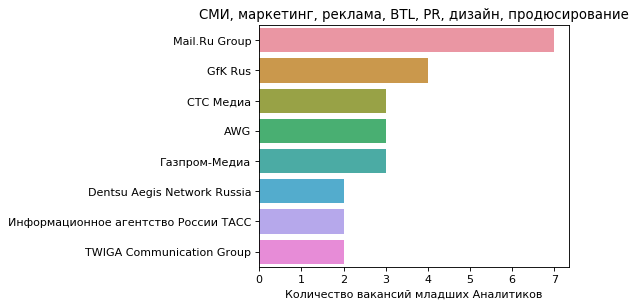

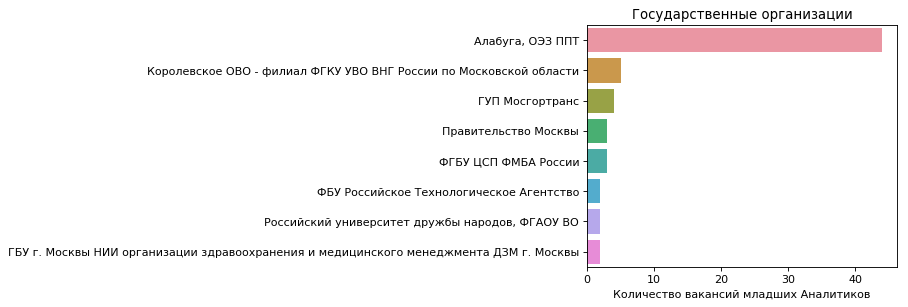

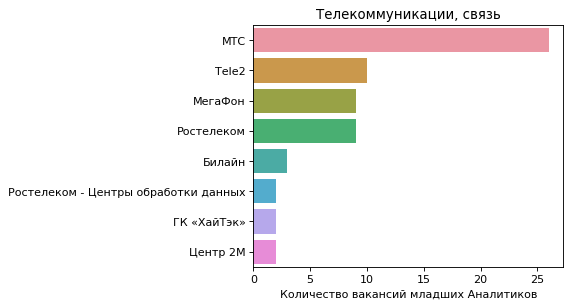

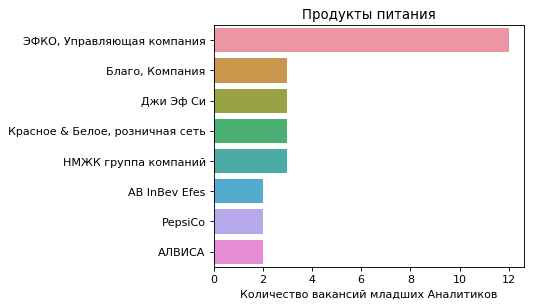

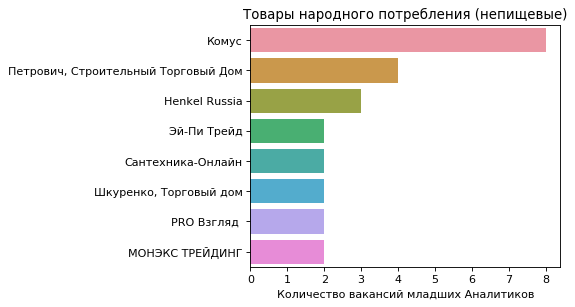

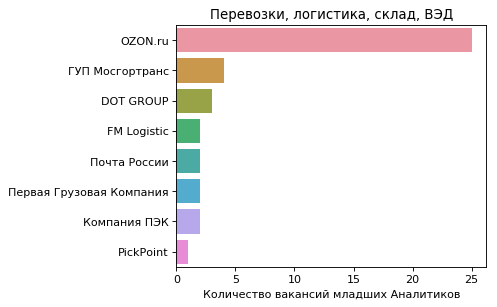

In [27]:
# построим графики с лидерами каждой отрасли по объему вакансий для начинающих аналитиков

for ind_top in range(len(top_filter)):
    data_filter = data[data['industry_name'] == top_filter[ind_top]].groupby('employer')['name'].count().sort_values(ascending=False).head(8).reset_index()
    plt.figure(figsize=(5,4), dpi= 80)
    sns.set_palette('PRGn')
    sns.barplot(y='employer', x='name', data=data_filter)
    plt.title(top_filter[ind_top] , fontsize=12)
    plt.xlabel('Количество вакансий младших Аналитиков')
    plt.ylabel('')
    plt.show()

## Оценка объема рынка вакансий младших аналитиков в Москве и Санкт-Петербурге <a id="volume"></a>

В результате загрузки данных о вакансиях с hh.ru у нас есть данные о вакансиях по Москве и Санкт-Петербургу в разрезе 2 категорий:

- без требовании о наличии опыта работы у соискателя
- с предъявляемым требованием к соискателю по минимальному опыту работы 1-3 года

In [28]:
# сколько различных городов представлено в выборке вакансий

data['city'].value_counts()

Москва                          1495
Санкт-Петербург                  243
Екатеринбург                      19
Киев                              17
Новосибирск                       16
                                ... 
Улан-Удэ                           1
Пушкино (Московская область)       1
Владимир                           1
Саранск                            1
Истра                              1
Name: city, Length: 77, dtype: int64

В нашей выборке представлено 77 городов из стран СНГ

In [29]:
# оценим общее число вакансий по целевым городам

sample_msk_spb = data.query('city == "Москва"|city == "Санкт-Петербург"').groupby('city')['url'].nunique()
sample_msk_spb

city
Москва             1126
Санкт-Петербург     198
Name: url, dtype: int64

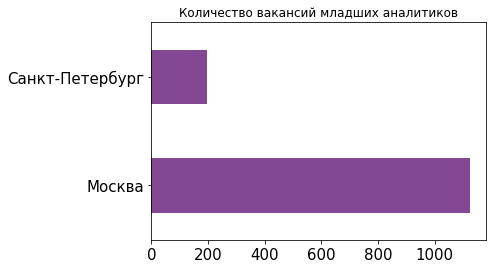

In [30]:
sample_msk_spb.plot(kind='barh', title='Количество вакансий младших аналитиков', fontsize='15');
plt.ylabel('');

Определим долю вакансий, не предъявляющих к соискателям опыт работы

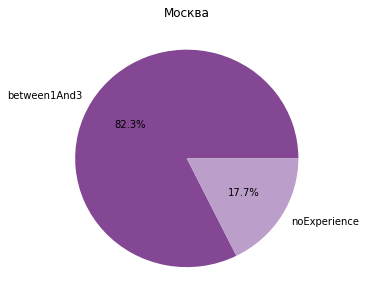

In [31]:
data.query('city == "Москва"').groupby('experience')['url'].nunique().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5), title='Москва')
plt.ylabel('');

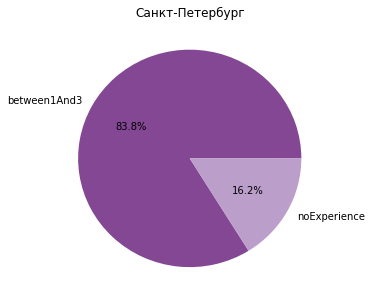

In [32]:
data.query('city == "Санкт-Петербург"').groupby('experience')['url'].nunique().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5), title='Санкт-Петербург')
plt.ylabel('');

Определим топовые отрасли, в которых открыты вакансии для младших аналитиков в городах

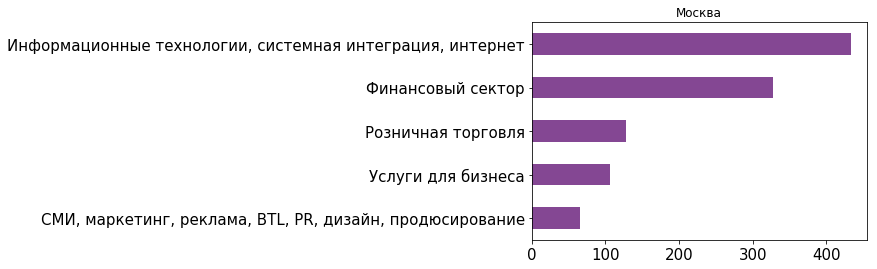

In [33]:
data.query('city == "Москва"')['industry_name'].value_counts().head(5).sort_values().plot(kind='barh', title='Москва', fontsize='15');
plt.ylabel('');

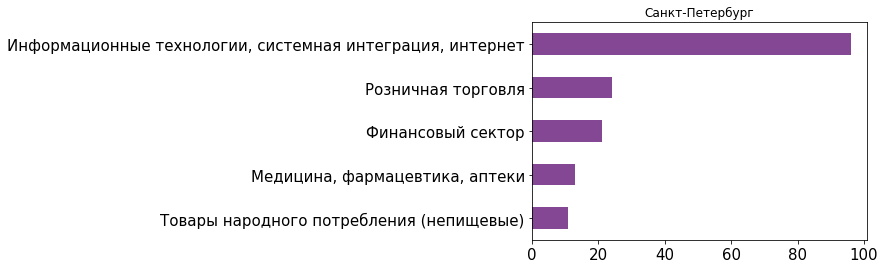

In [34]:
data.query('city == "Санкт-Петербург"')['industry_name'].value_counts().head(5).sort_values().plot(kind='barh', title='Санкт-Петербург', fontsize='15');
plt.ylabel('');

## Выводы и рекомендации <a id="summary"></a>

Для исследования были загружены данные по запросу к hh.ru об актуальных вакансиях младших аналитиков с 3 марта по 29 апреля 2020 из 77 городов стран СНГ.

Работодатели поделены на сегменты относительно отраслей деятельности компании, в которых открыт набор сотрудников на должности младших аналитиков.

Абсолютными лидерами по открытым вакансиям аналитиков стали компании отрасли Информационных технологий и финаносвого сектора.

Оказалось, рынок отраслей, в которых открыты вакансии для младших аналитиков отличаются в Москве и Санкт-Петербурге:

- Только 3 отрасли из 5 попали в оба топа по городам: информационные технологии, финансовый сектор и розничная торговля
- Медицина и отрасль товары народного потребления преобладают в Санкт-Петербурге
- Услуги для бизнеса и СМИ/продюсирование - в Москве

Возможные причины выявленных различий:

- Отрасль "Услуги для бизнеса" в полученной выборке в большей степени представлены крупными компаниями-рекрутерами, в том числе международными. Их сфера деятельности сосредоточена в столице.

- "СМИ, маркетинг, реклама" объясняется локацией медиа-холдингов в Москве.

**Рекомендации для соискателей:**

К сожалению, вакансий, не требующих опыта работы от соискателей, на рынке трудоустройства очень мало. В основном это вакансии стажировок для выпускников ВУЗов. Поэтому откликаться стоит и на вакансии, где указан опыт работы от 1 года до 3.

Сегментация по отрасли деятельности работодателей в исследовании имеет практическое значение. При отклике на вакансию, всегда надо иметь ввиду, что работодатель ждет от соискателя, кроме хард и софт скилов, базового знакомства с предметной областью его деятельности и проявления интереса к ней.  